In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import datetime
import optuna
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler, GridSampler
from sklearn.manifold import TSNE
from keras.callbacks import TensorBoard
from tqdm import tqdm


2023-12-17 00:41:31.993776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 00:41:31.993800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 00:41:31.994418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 00:41:31.998302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 00:41:32.810912: W tensorflow/compiler/tf2

In [2]:
folds = 10
n_trials = 150

(50000, 32, 32, 3)


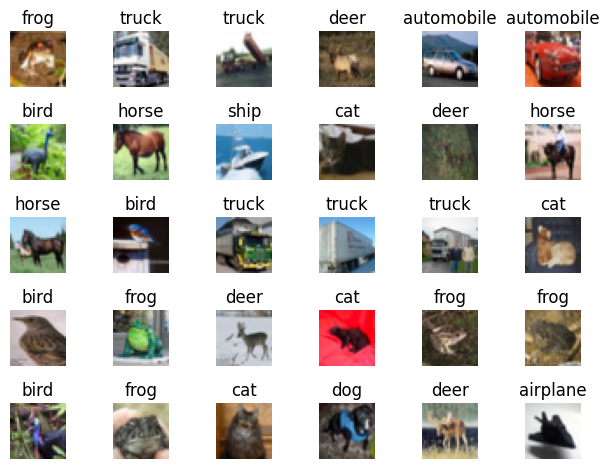

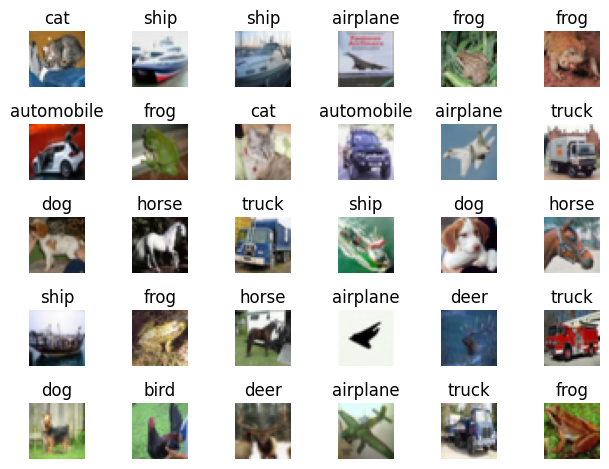

num_class: 10


In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)

#ラベルの設定
labels = np.array([
    'airplane',  #飛行機
    'automobile',#バイク
    'bird',      #鳥
    'cat',       #猫
    'deer',      #鹿
    'dog',       #犬
    'frog',      #カエル
    'horse',     #馬
    'ship',      #船
    'truck'      #トラック
    ])

#画像の表示のための関数
def image_show(x, y, labels):
    for i in range(30):
        plt.subplot(5, 6, i+1)
        #軸を表示しない
        plt.axis("off")
        #タイトルをラベルの名前で表示
        plt.title(labels[y[i][0]])
        #表示
        plt.imshow(x[i])
    plt.tight_layout()
    plt.show()
    return    

# トレーニングデータの画像とラベルをセットで表示してみる
image_show(X_train, y_train, labels)
image_show(X_test, y_test, labels)

# データの前処理
# ラベルをバイナリクラスにする(yの値を10この数値の配列に変換している)
categorical_y_train = to_categorical(y_train, 10)
categorical_y_test = to_categorical(y_test, 10)

# 正解ラベルの中身の種類 (0~9)をlistに格納
class_list = np.unique(y_train).tolist()
num_class = len(class_list)
print("num_class:", num_class)

In [4]:
# ImageDataGeneratorクラスの作成
augmentation_train_datagen = ImageDataGenerator(
    rotation_range=10,          # 回転
    horizontal_flip=True,       # 左右反転
    height_shift_range=0.2,     # 上下平行移動
    width_shift_range=0.2,      # 左右平行移動
    zoom_range=0.2,             # ランダムにズーム
    channel_shift_range = 0.2   # チャンネルシフト
)

In [13]:
def create_model(trial):
    # モデル作成時のパラメータを設定
    # モデル作成時のパラメータを設定
    n_layers = trial.suggest_int('n_layers', 1, 5)
    units = trial.suggest_int('n_units', 8, 256, step=8)
    kernel = 3
    pool = 2
    drop = trial.suggest_float('drop', 0.1, 0.75, step=0.05)

    inputs = Input(shape=(32, 32, 3))
    x = Conv2D(64, (3,3), padding = "same", activation="relu")(inputs)

    for i in range(n_layers):
        x = Conv2D(units/2**(i-1), (kernel,kernel), padding="same", activation="relu")(x)
        x = MaxPooling2D(pool_size=(pool,pool))(x)
        x = Dropout(drop)(x)

    x = Conv2D(32, (kernel,kernel), padding="same", activation="relu")(x)

    # 平滑化
    x = Flatten()(x)

    # 全統合
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.6)(x)
    predictions = Dense(num_class, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"]
                    )
    
    return model

In [6]:
def objective(trial):
    # モデルの作成
    model = create_model(trial)

    # batch_size範囲を指定
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)
    epochs = trial.suggest_int('epochs', 2, 100, step=7)

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    print("num_X_train:", len(X_train))
    
    accuracies = []
    for train_index, valid_index in kf.split(X_train, categorical_y_train):
        X_train_subset = X_train[train_index]
        y_train_subset = categorical_y_train[train_index]
        X_valid_subset = X_train[valid_index]
        y_valid_subset = categorical_y_train[valid_index]

        # 学習
        model.fit(X_train_subset, y_train_subset,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_valid_subset, y_valid_subset),
                        callbacks=[EarlyStopping(patience=10)]
        )

        # 予測
        y_pred_subset = model.predict(X_valid_subset)

        # 予測したものを元のカテゴリクラスに変換する
        y_pred_subset = np.argmax(y_pred_subset, axis=1)
        y_valid_subset = np.argmax(y_valid_subset, axis=1)

        # 正解数をカウント
        num_correct = np.sum(y_pred_subset == y_valid_subset)
        print("num_correct:", num_correct)

        # valid_index の数
        num_valid_samples = len(y_valid_subset)
        print("num_valid_samples:", num_valid_samples)

        # 正解率
        accuracy = num_correct / num_valid_samples
        print("accuracy:", accuracy)

        # 正解率をリストにappend
        accuracies.append(accuracy)

    # CVのaccuracyの平均値を目的関数として返す
    print(np.mean(accuracies))
    return np.mean(accuracies)


# ベイズ最適化
sampler = TPESampler()
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=n_trials)
# 最適なパラメータの表示
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

model, intermediate_layer_model = create_model(study.best_trial)

[I 2023-12-17 00:41:39,985] A new study created in memory with name: no-name-f9ba90a5-f5e8-46e4-a89f-a98ed048a981


num_X_train: 50000
Epoch 1/65
313/313 [==============================] - 136s 428ms/step - loss: 2.3856 - accuracy: 0.1345 - val_loss: 2.4136 - val_accuracy: 0.0970
Epoch 2/65
313/313 [==============================] - 136s 434ms/step - loss: 2.0660 - accuracy: 0.1832 - val_loss: 2.6391 - val_accuracy: 0.0976
Epoch 3/65
313/313 [==============================] - 146s 468ms/step - loss: 1.9771 - accuracy: 0.1878 - val_loss: 2.4956 - val_accuracy: 0.0986
Epoch 4/65
313/313 [==============================] - 148s 473ms/step - loss: 1.9390 - accuracy: 0.1912 - val_loss: 2.5500 - val_accuracy: 0.0974
Epoch 5/65
313/313 [==============================] - 147s 471ms/step - loss: 1.9179 - accuracy: 0.1992 - val_loss: 2.4307 - val_accuracy: 0.1060
Epoch 6/65
313/313 [==============================] - 149s 477ms/step - loss: 1.9044 - accuracy: 0.1997 - val_loss: 2.4917 - val_accuracy: 0.1036
Epoch 7/65
313/313 [==============================] - 148s 474ms/step - loss: 1.8929 - accuracy: 0.2073 -

[I 2023-12-17 08:12:21,224] Trial 0 finished with value: 0.32484 and parameters: {'n_layers': 5, 'n_units': 104, 'drop': 0.55, 'batch_size': 144, 'epochs': 65}. Best is trial 0 with value: 0.32484.


num_correct: 1111
num_valid_samples: 5000
accuracy: 0.2222
0.32484
num_X_train: 50000
Epoch 1/16
938/938 [==============================] - 297s 316ms/step - loss: 2.4419 - accuracy: 0.1002 - val_loss: 2.2962 - val_accuracy: 0.1122
Epoch 2/16
938/938 [==============================] - 297s 316ms/step - loss: 2.3009 - accuracy: 0.1048 - val_loss: 2.2937 - val_accuracy: 0.1108
Epoch 3/16
938/938 [==============================] - 297s 316ms/step - loss: 2.2812 - accuracy: 0.1281 - val_loss: 2.2711 - val_accuracy: 0.1360
Epoch 4/16
938/938 [==============================] - 296s 315ms/step - loss: 2.2064 - accuracy: 0.1619 - val_loss: 1.8138 - val_accuracy: 0.3296
Epoch 5/16
938/938 [==============================] - 294s 313ms/step - loss: 1.6140 - accuracy: 0.4156 - val_loss: 1.3188 - val_accuracy: 0.5076
Epoch 6/16
938/938 [==============================] - 291s 310ms/step - loss: 1.3407 - accuracy: 0.5216 - val_loss: 1.1679 - val_accuracy: 0.5772
Epoch 7/16
938/938 [==================

[I 2023-12-17 19:09:40,976] Trial 1 finished with value: 0.8160000000000001 and parameters: {'n_layers': 2, 'n_units': 184, 'drop': 0.2, 'batch_size': 48, 'epochs': 16}. Best is trial 1 with value: 0.8160000000000001.


num_correct: 4342
num_valid_samples: 5000
accuracy: 0.8684
0.8160000000000001
num_X_train: 50000
Epoch 1/2
704/704 [==============================] - 240s 340ms/step - loss: 2.5888 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0970
Epoch 2/2
157/157 [==============================] - 6s 37ms/step
num_correct: 509
num_valid_samples: 5000
accuracy: 0.1018
Epoch 1/2
704/704 [==============================] - 241s 342ms/step - loss: 2.3031 - accuracy: 0.1008 - val_loss: 2.3025 - val_accuracy: 0.1022
Epoch 2/2
157/157 [==============================] - 6s 37ms/step
num_correct: 447
num_valid_samples: 5000
accuracy: 0.0894
Epoch 1/2
704/704 [==============================] - 240s 341ms/step - loss: 2.3027 - accuracy: 0.1002 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 2/2
157/157 [==============================] - 6s 37ms/step
num_correct: 473
num_valid_samples: 5000
accuracy: 0.0946
Epoch 1/2
704/704 [==============================] - 240s 341ms/step - loss: 2.3021 - accuracy: 

[I 2023-12-17 20:30:37,013] Trial 2 finished with value: 0.20364 and parameters: {'n_layers': 1, 'n_units': 184, 'drop': 0.65, 'batch_size': 64, 'epochs': 2}. Best is trial 1 with value: 0.8160000000000001.


num_correct: 2075
num_valid_samples: 5000
accuracy: 0.415
0.20364
    n_layers: 2
    n_units: 184
    drop: 0.2
    batch_size: 48
    epochs: 16


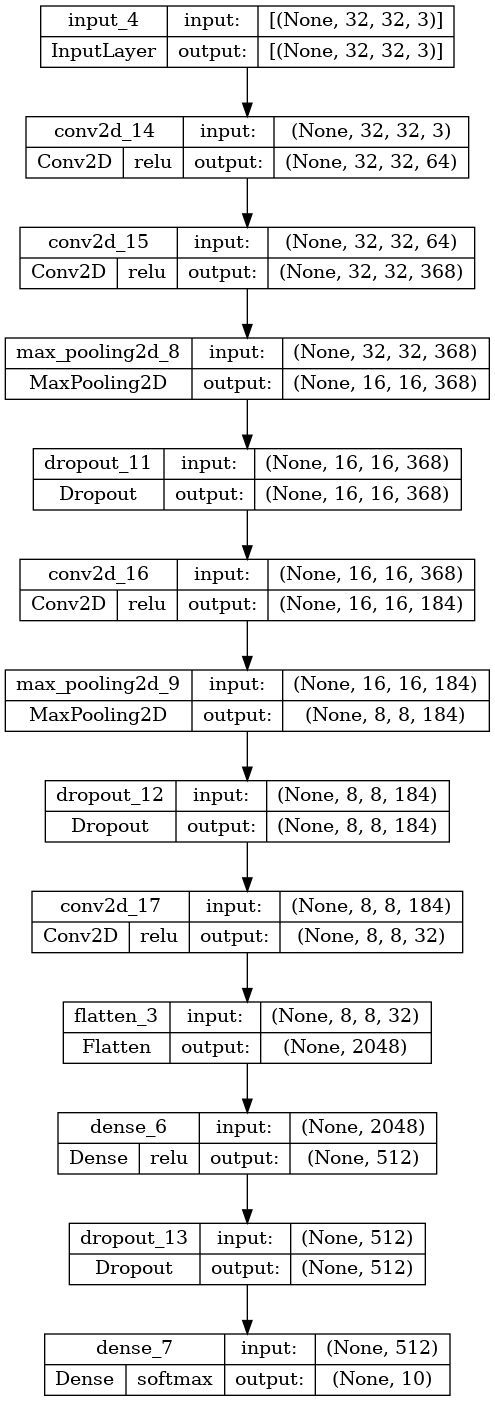

In [7]:
keras.utils.plot_model(model, to_file="/home/gakubu/デスクトップ/ML_git/MLT/ML_11/model.png", 
                        show_shapes=True, show_layer_activations="True")

In [8]:
# tensorboard を使用
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
batch_size = study.best_trial.params['batch_size']
epochs = study.best_trial.params['epochs']
model.fit(X_train, categorical_y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, categorical_y_test),
        callbacks=[tensorboard_callback, EarlyStopping(patience=10)]
)

Epoch 1/16
1042/1042 [==============================] - 327s 313ms/step - loss: 2.4134 - accuracy: 0.0984 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/16
1042/1042 [==============================] - 330s 317ms/step - loss: 2.3031 - accuracy: 0.1021 - val_loss: 2.3026 - val_accuracy: 0.1004
Epoch 3/16
1042/1042 [==============================] - 326s 313ms/step - loss: 2.3033 - accuracy: 0.0983 - val_loss: 2.3015 - val_accuracy: 0.1010
Epoch 4/16
1042/1042 [==============================] - 332s 319ms/step - loss: 2.3031 - accuracy: 0.1003 - val_loss: 2.3016 - val_accuracy: 0.1019
Epoch 5/16
1042/1042 [==============================] - 329s 316ms/step - loss: 2.3033 - accuracy: 0.1005 - val_loss: 2.3026 - val_accuracy: 0.1003
Epoch 6/16
1042/1042 [==============================] - 331s 317ms/step - loss: 2.3032 - accuracy: 0.1009 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/16
1042/1042 [==============================] - 329s 316ms/step - loss: 2.3036 - accuracy: 0.0990 - val_

313/313 [==============================] - 15s 49ms/step
y_test_pred_labels: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
y_test: [[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
misclassified_indices: [   0    1    2 ... 9997 9998 9999]
Num miss categorized: 9000


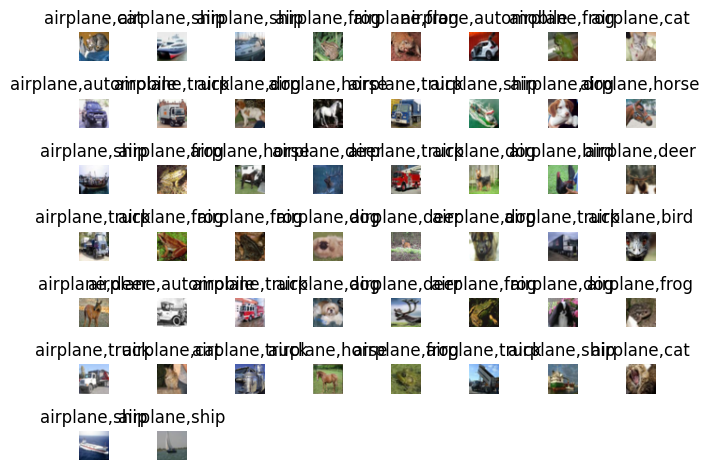

num_correct: 1000
num_valid_samples: 10000
accuracy: 0.1


In [10]:
# テストデータに対する予測
y_test_pred = model.predict(X_test)
# 予測したものを元のカテゴリクラスに変換する
y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_pred_labels = y_test_pred.reshape(-1, 1)
# データの形を確認
print("y_test_pred_labels:", y_test_pred_labels)
print("y_test:", y_test)
# 予測と正解ラベルが異なる画像のインデックスを取得
misclassified_indices = np.where(y_test_pred != np.argmax(categorical_y_test, axis=1))[0]
print("misclassified_indices:", misclassified_indices)
# 表示する画像の枚数
num_images_to_display = min(50, len(misclassified_indices))
num_miss_categorized = len(misclassified_indices)
print("Num miss categorized:", num_miss_categorized)
# グリッドの行数と列数を計算
num_rows = int(np.sqrt(num_images_to_display))
num_cols = int(np.ceil(num_images_to_display / num_rows))
# 誤分類された画像を表示
for i in range(num_images_to_display):
    index = misclassified_indices[i] 

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(X_test[index])
    plt.axis("off")
    titles = labels[y_test_pred_labels[index][0]] + "," + labels[y_test[index][0]]
    plt.title(titles)
plt.tight_layout()
plt.show()

# 正解数をカウント
num_correct = len(y_test) - num_miss_categorized

# valid_index の数
num_valid_samples = len(y_test)

# 正解率
print("num_correct:", num_correct)
print("num_valid_samples:", num_valid_samples)
accuracy = num_correct / num_valid_samples
print("accuracy:", accuracy)

In [14]:
# # # 中間層の出力を取得
# intermediate_output = intermediate_layer_model.predict(X_train)
# # t-SNEによる次元削減
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(intermediate_output)
# print(tsne_result.shape)
# # プロット
# scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_train.flatten(), cmap="tab10")
# plt.legend(*scatter.legend_elements())
# plt.title('t-SNE Visualization of Convolutional Features')
# plt.show()

AttributeError: 'KerasTensor' object has no attribute 'predict'